##### После этого можно начать анализ мишеней: 

- Нужно узнать, сколько аптамеров подходят к каждой.

In [24]:
# Создаем таблицу: мишень и сколько для неё есть аптамеров
target_table = df_final.groupby('canonical_smiles')['sequence'].count().reset_index()

target_table.columns = ['Мишень', 'Количество аптамеров']

# Сортируем 
target_table = target_table.sort_values(by='Количество аптамеров', ascending=False)

pd.set_option('display.max_rows', None)

top_targets = target_table[target_table['Количество аптамеров'] > 3]

print(top_targets)

pd.reset_option('display.max_rows')

                                                Мишень  Количество аптамеров
137     COC(=O)[C@@H]1C2CCC(C[C@@H]1OC(=O)c1ccccc1)N2C                    65
290                                  N[C@@H](CS)C(=O)O                    52
230  NCC1OC(OC2C(CO)OC(OC3C(O)C(N)CC(N)C3OC3OC(CN)C...                    26
47              CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1                    23
148  COc1cc2c(c3oc(=O)c4c(c13)CCC4=O)[C@]1(O)C=CO[C...                    20
198                         Cn1c(=O)c2[nH]cnc2n(C)c1=O                    18
331                                               [As]                    18
142      COc1cc(C=CC(=O)CC(=O)C=Cc2ccc(O)c(OC)c2)ccc1O                    18
43   CC1Cc2c(Cl)cc(C(=O)NC(Cc3ccccc3)C(=O)O)c(O)c2C...                    16
28   CC(C)[C@H](NC(=O)c1nn(Cc2ccc(F)cc2)c2ccccc12)C...                    15
257                                               NCCO                    13
163  C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...                    11

Для того чтобы найти короткий общий scaffold в разных по размеру цепях, мы будем использовать local аlignment. Оно игнорирует несовпадающие концы и ищет только область максимального сходства.

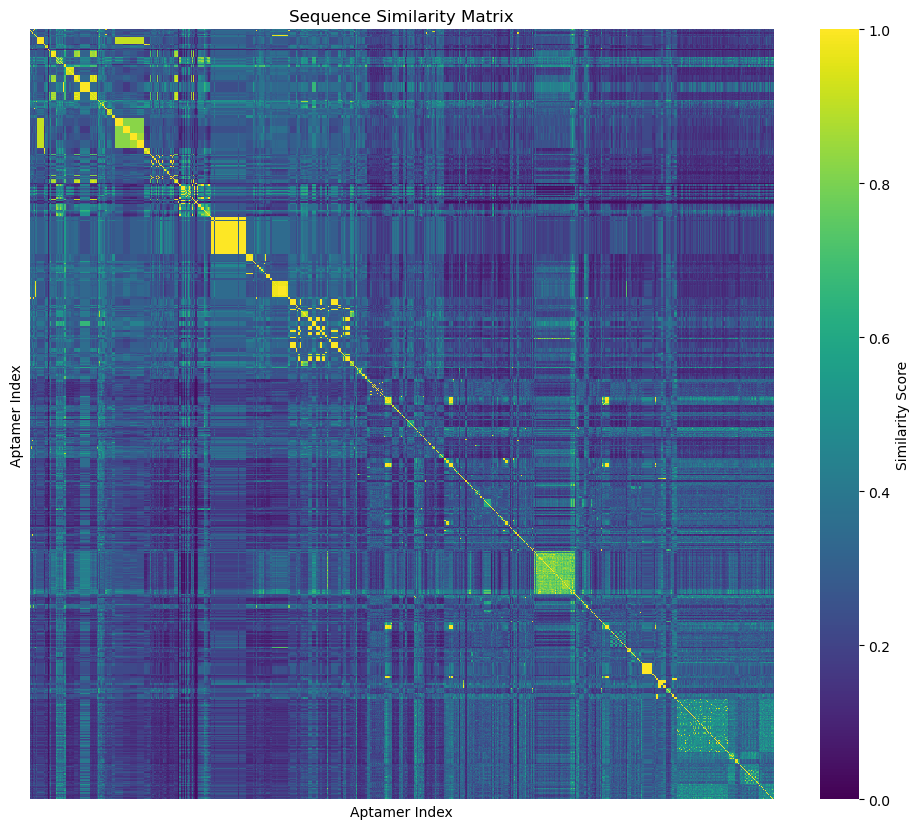

In [25]:
# Настройка выравнивания
aligner = Align.PairwiseAligner()
aligner.mode = 'local' 

try:
    aligner.open_gap_penalty = 2.0
    aligner.extend_gap_penalty = 0.5
except AttributeError:
    aligner.gap_score = -2.0

aligner.match_score = 2.0
aligner.mismatch_score = -1.0

def get_similarity(seq1, seq2):
    # Находим лучший score между двумя цепочками
    score = aligner.score(seq1, seq2)
    
    # Нормализация: делим на максимально возможный score (если бы seq1 совпала сама с собой)
    # Это дает нам значение от 0 до 1, где 1 — идеальное совпадение "кусочка"
    max_score = min(len(seq1), len(seq2)) * aligner.match_score
    return score / max_score

# Similarity Matrix
sequences = df_final['sequence'].tolist()
n = len(sequences)
matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        sim = get_similarity(sequences[i], sequences[j])
        matrix[i, j] = sim
        matrix[j, i] = sim

# Визуализация

plt.figure(figsize=(12, 10))

sns.heatmap(
    matrix, 
    cmap='viridis', 
    xticklabels=False, 
    yticklabels=False, 
    cbar_kws={'label': 'Similarity Score'}
)

plt.title('Sequence Similarity Matrix')
plt.xlabel('Aptamer Index')
plt.ylabel('Aptamer Index')

plt.show()

In [26]:
distance = 1 - matrix

# Модель кластеризации
model = AgglomerativeClustering(
    n_clusters=None,   
    distance_threshold=0.3,  # Последовательности должны быть схожи на 70%
    metric='precomputed',   
    linkage='average'      
)

# Вычисляем кластеры
labels = model.fit_predict(distance)

scaffold_map = pd.DataFrame({
    'sequence': sequences,
    'scaffold_id': labels
})

df_cluster = df_final.merge(scaffold_map, on='sequence', how='left')

Визуализируем кластеры:

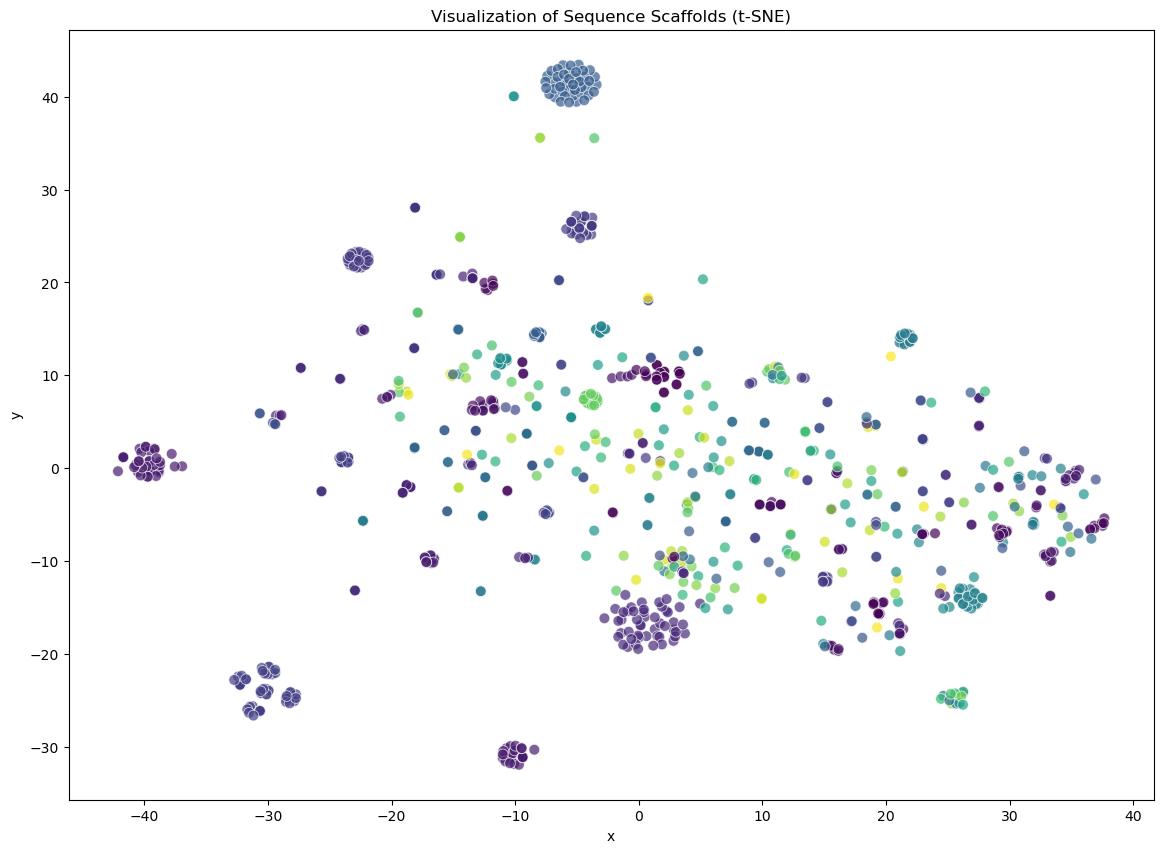

In [27]:
tsne = TSNE(n_components=2, perplexity=30, metric='precomputed', init='random', random_state=42)
vis_coords = tsne.fit_transform(distance)

# Добавляем координаты в наш список для удобства
vis_df = pd.DataFrame({
    'x': vis_coords[:, 0],
    'y': vis_coords[:, 1],
    'cluster': labels
})

# 3. Рисуем красивый Scatter Plot
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=vis_df, 
    x='x', y='y', 
    hue='cluster',     # Раскрашиваем по номеру кластера
    palette='viridis', # Цветовая схема
    legend=None,
    alpha=0.7,
    s=60              # Размер точек
)

plt.title('Visualization of Sequence Scaffolds (t-SNE)')
plt.show()

In [ ]:
# добавляем в таблицу с датасетом айди скаффолда

scaffold_stats = df_cluster.groupby('scaffold_id').agg({
    'sequence': 'count',           
    'canonical_smiles': 'nunique' 
}).rename(columns={'sequence': 'aptamer_count', 'canonical_smiles': 'unique_targets'})

In [33]:
def get_full_scaffold_analysis(data,
                               sort_by='unique_targets',
                               min_apt=0,
                               min_targets=0,
                               min_freq=0):
    """
    data: dataframe (df_cluster), в котором есть:
          - scaffold_id
          - sequence
          - canonical_smiles
          
    sort_by: 'unique_targets', 'aptamer_count', 'frequency_%',
             'GC_%', 'target_diversity_ratio', 'specificity_index'
             
    min_apt: минимальное число аптамеров
    min_targets: минимальное число уникальных мишеней
    min_freq: минимальная частота (%)
    """

    total_rows = len(data)

# Группирую по айди кластера

    stats = data.groupby('scaffold_id').agg(
        aptamer_count=('sequence', 'count'), # Считаем, сколько аптамеров входит в этот кластер
        scaffold_sequence=('sequence', lambda x: x.mode()[0]), # Берем самую частую последовательность
        unique_targets=('canonical_smiles', 'nunique') # Считаем мишени
    ).reset_index()

    # длина scaffold 
    stats['length'] = stats['scaffold_sequence'].apply(len) 

    # GC% - GC-состав важен для аптамеров: высокий процент часто указывает на стабильные шпильки или G-квартеты, но слишком высокий (>75-80%) может быть признаком мусорной последовательности.
    def gc_content(seq):
        gc = seq.count('G') + seq.count('C')
        return round(gc / len(seq) * 100, 2)

    stats['GC_%'] = stats['scaffold_sequence'].apply(gc_content)

    # частота
    stats['frequency_%'] = round((stats['aptamer_count'] / total_rows) * 100, 2)

    # коэффициенты
    # Если он близок к 1, то каждая последовательность в кластере бьет в новую мишень (это очень универсальный скаффолд).
    stats['target_diversity_ratio'] = round(
        stats['unique_targets'] / stats['aptamer_count'], 3
    )

    # Если он высокий, значит, у нас есть много вариантов одной и той же структуры под одну мишень (высокая селективность).
    stats['specificity_index'] = round(
        stats['aptamer_count'] / stats['unique_targets'], 3
    )

    # классификация
    def classify(row):
        # Если встречается очень часто и у многих мишеней - это структурный "каркас"
        if row['frequency_%'] > 20 and row['unique_targets'] > 20:
            return 'Universal structural scaffold'
        # Если много G и C и много мишеней — это, скорее всего, G-квартет или жесткая шпилька
        elif row['GC_%'] > 75 and row['unique_targets'] > 10:
            return 'GC-rich'
        # Если на много аптамеров мало мишеней — это узкоспециализированный кандидат
        elif row['target_diversity_ratio'] < 0.3:
            return 'Target-specific candidate'
        # Всё остальное
        else:
            return 'Functional candidate'

    stats['scaffold_type'] = stats.apply(classify, axis=1)

    # фильтры
    stats = stats[
        (stats['aptamer_count'] >= min_apt) &
        (stats['unique_targets'] >= min_targets) &
        (stats['frequency_%'] >= min_freq)
    ]

    # сортировка
    if sort_by in stats.columns:
        stats = stats.sort_values(by=sort_by, ascending=False)

    print(f"\n SEQUENCE-LEVEL SCAFFOLD ANALYSIS \n")
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.max_colwidth', 60):
        display(stats)

    return stats


# Запуск
final_results = get_full_scaffold_analysis(
    df_cluster,
    sort_by='aptamer_count',
    min_apt=1,
    min_targets=1,
    min_freq=0
)


 SEQUENCE-LEVEL SCAFFOLD ANALYSIS 



,scaffold_id,aptamer_count,scaffold_sequence,unique_targets,length,GC_%,frequency_%,target_diversity_ratio,specificity_index,scaffold_type
98,98,1849,GAGCGUCACACCUUCGGGUGAAGUCGCUC,42,29,62.07,39.49,0.023,44.024,Universal structural scaffold
63,63,405,AUUUUUCCUCGAACCCGGCGGAACGCAGAAAAAU,9,34,47.06,8.65,0.022,45.000,Target-specific candidate
53,53,361,GGCAGAUCUGAGCCUGGGAGCUCUCUGCC,19,29,65.52,7.71,0.053,19.000,Target-specific candidate
59,59,262,UUUUUUAGGGAAGAUCUGGCCUUCCCACAAGGGAAGGCCAGGGAAUUUUCUU,19,52,46.15,5.60,0.073,13.789,Target-specific candidate
258,258,196,UGUGGGAGGGGCGGGUCUGGG,14,21,76.19,4.19,0.071,14.000,GC-rich
25,25,127,GGGAGAGGGUUUAAUUCGGUACGAAAGUACGGAUUGGAUCCGCAAGG,20,47,51.06,2.71,0.157,6.350,Target-specific candidate
26,26,118,GGGCCUAAAACAUACCAGAUCGCCACCCGCGCUUUAAUCUGGAGAGGUGAAGAAUA...,12,71,53.52,2.52,0.102,9.833,Target-specific candidate
141,141,109,CGGATCCCCAGCTCGGGGTGCTATGGAGGCTGTATCGGAGACCTGCAGG,10,49,65.31,2.33,0.092,10.900,Target-specific candidate
0,0,66,CGGCGGCGGCGGCGGCGGCGGCGGCGGCGGCGGCGG,11,36,100.00,1.41,0.167,6.000,GC-rich
99,99,64,AGCCCCUGCCCACCGCACACUGCGCUGCCCCAGACCCACUGUGCGUGUGACAGCGG...,6,60,70.00,1.37,0.094,10.667,Target-specific candidate


### Sequence-level Scaffold Analysis

В рамках анализа scaffold-ов на уровне последовательности были рассчитаны следующие параметры:

- количество аптамеров, содержащих scaffold (`aptamer_count`)
- частота scaffold в датасете (`frequency_%`)
- количество уникальных мишеней (`unique_targets`)
- коэффициент разнообразия мишеней (`target_diversity_ratio`)
- индекс специфичности (`specificity_index`)
- GC-состав последовательности (`GC_%`)

#### Sequence-level Scaffold Metrics

Для количественного анализа scaffold-ов на уровне последовательности были введены дополнительные метрики, позволяющие оценить их распространённость, структурные свойства и потенциальную специфичность связывания.

Ниже приведены используемые параметры и их интерпретация.

---

##### 1. Aptamer Count (`aptamer_count`)

Количество аптамеров в датасете, содержащих данный scaffold.

$$
\text{aptamer\_count} = \left| \{ a_i \in A \; | \; \text{scaffold} \subset a_i \} \right|
$$

где:
- $A$ — множество всех аптамеров в датасете  
- $a_i$ — отдельный аптамер  

**Зачем:**  
Позволяет оценить, насколько широко scaffold представлен в библиотеке. Высокое значение может указывать либо на функциональную значимость, либо на амплификационное смещение.

##### 2. Unique Targets (`unique_targets`)

Количество уникальных молекул (мишеней), с которыми связываются аптамеры данного scaffold.

$$
\text{unique\_targets} = \left| \{ t_j \in T \; | \; a_i \rightarrow t_j \} \right|
$$

где:
- $T$ — множество всех мишеней  
- $a_i \rightarrow t_j$ означает, что аптамер $a_i$ связывает мишень $t_j$

**Зачем:**  
Показывает широту связывания scaffold-а.  
Большое значение → возможная универсальность или неспецифическое связывание.  
Малое значение → потенциальная специфичность.


##### 3. Frequency (%) (`frequency_%`)

Доля scaffold-а в общем датасете.

$$
\text{frequency}_{\%} =
\frac{\text{aptamer\_count}}{N_{\text{total}}} \times 100
$$

где:
- $N_{\text{total}}$ — общее число записей в датасете

**Зачем:**  
Позволяет оценить степень обогащения scaffold-а.  
Очень высокая частота может свидетельствовать о:
- структурной устойчивости (например, GC-rich мотивы),
- PCR bias,
- универсальном структурном каркасе.

##### 4. Length (`length`)

Длина последовательности scaffold-а.

$$
\text{length} = |\text{scaffold\_sequence}|
$$

**Зачем:**  
Длина влияет на структурный потенциал.  
Короткие повторяющиеся мотивы чаще являются артефактами, тогда как более длинные последовательности способны формировать сложные вторичные структуры.

##### 5. GC Content (%) (`GC_%`)

Процент гуаниновых и цитозиновых оснований.

$$
GC_{\%} =
\frac{N_G + N_C}{\text{length}} \times 100
$$

где:
- $N_G$ — количество гуанинов  
- $N_C$ — количество цитозинов  

**Зачем:**  
Высокий GC-состав:
- повышает термодинамическую стабильность,
- способствует формированию жёстких стеблей,
- увеличивает вероятность G-квадруплексных структур,
- может приводить к амплификационному обогащению.

Очень высокий GC% (>75%), потенциально PCR bias или G-quadruplex functional motif или Universal structural scaffold


##### 6. Target Diversity Ratio (`target_diversity_ratio`)

Отношение числа уникальных мишеней к числу аптамеров.

$$
\text{target\_diversity\_ratio} =
\frac{\text{unique\_targets}}{\text{aptamer\_count}}
$$

**Интерпретация:**

- Значение близкое к 1 → почти каждый аптамер связывает разную молекулу  
  → scaffold универсальный или неспецифический.

- Низкое значение (<0.3) → много аптамеров на ограниченный набор мишеней  
  → потенциально специфичный scaffold.

**Зачем:**  
Позволяет отличить универсальные структурные элементы от селективных мотивов.


##### 7. Specificity Index (`specificity_index`)

Обратная величина разнообразия:

$$
\text{specificity\_index} =
\frac{\text{aptamer\_count}}{\text{unique\_targets}}
$$

**Интерпретация:**

- Высокое значение → scaffold концентрируется на ограниченном наборе мишеней  
  → возможный специфический связывающий мотив.

- Низкое значение → scaffold используется для множества разных молекул  
  → универсальный структурный элемент.

**Зачем:**  
Помогает выявить scaffold-ы, которые селективно обогащаются при связывании конкретных молекул.


Таким образом, количественный sequence-level анализ позволяет отделить:

- структурные каркасы,
- G-богатые мотивы,
- потенциально специфические связывающие scaffold-ы,

что является первым этапом перед переходом к анализу вторичной и третичной структуры.

---

#### Общие наблюдения

1. Высокочастотные scaffold-ы, встречающиеся в большом числе аптамеров и связывающие большое количество различных мишеней, вероятно являются универсальными структурными элементами.  
   Такие мотивы часто характеризуются:
   - высокой GC-насыщенностью,
   - наличием G-кластеров,
   - потенциальной способностью к образованию G-квадруплексов,
   - повышенной термодинамической стабильностью.

   Они могут обогащаться в процессе SELEX независимо от специфического связывания, за счёт структурной устойчивости и PCR-bias.

2. Scaffold-ы с высоким значением `specificity_index` и низким `target_diversity_ratio` вероятнее всего участвуют в специфическом связывании ограниченного набора мишеней.  
   Такие последовательности не демонстрируют экстремальных повторов и имеют сбалансированный GC/AU состав, что характерно для функциональных аптамеров.

3. Короткие повторяющиеся мотивы и гомополимерные участки (например, GGGGG, AUUCUA×n, CCCCC) с высокой встречаемостью и широкой мишенной представленностью вероятно являются следствием амплификационного смещения и не отражают истинную селективность.

#### Вывод

Sequence-level анализ позволяет разделить scaffold-ы на:

- универсальные структурные элементы,
- потенциальные функциональные связывающие мотивы,
- G-богатые структурные каркасы,
- вероятные PCR-артефакты.

Дальнейший анализ на уровне вторичной и третичной структуры позволит уточнить, какие из scaffold-ов формируют специфические карманы связывания, а какие выполняют роль общего структурного каркаса.